In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/posts-csv/Posts.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from patsy import dmatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
import io
import plotly as pl
import plotly_express as px
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('/kaggle/input/posts-csv/Posts.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78926 entries, 0 to 78925
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     78926 non-null  int64  
 1   PostTypeId             78926 non-null  int64  
 2   CreationDate           78926 non-null  object 
 3   Score                  78926 non-null  int64  
 4   ViewCount              36775 non-null  float64
 5   Body                   78758 non-null  object 
 6   OwnerUserId            78448 non-null  float64
 7   LastActivityDate       78926 non-null  object 
 8   Title                  36775 non-null  object 
 9   Tags                   36775 non-null  object 
 10  AnswerCount            36775 non-null  float64
 11  CommentCount           78926 non-null  int64  
 12  ClosedDate             2246 non-null   object 
 13  ContentLicense         78926 non-null  object 
 14  AcceptedAnswerId       12190 non-null  float64
 15  La

In [5]:
df.head(5)

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,ClosedDate,ContentLicense,AcceptedAnswerId,LastEditorUserId,LastEditDate,ParentId,OwnerDisplayName,CommunityOwnedDate,LastEditorDisplayName,FavoriteCount
0,5,1,2014/5/13 23:58,9,968.0,<p>I've always been interested in machine lear...,5.0,2014/5/14 0:36,How can I do simple machine learning without h...,|machine-learning|,...,2014/5/14 14:40,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,1,2014/5/14 0:11,4,510.0,"<p>As a researcher and instructor, I'm looking...",36.0,2014/5/16 13:45,What open-source books (or other materials) pr...,|education|open-source|,...,2014/5/14 8:40,CC BY-SA 3.0,10.0,97.0,2014/5/16 13:45,NaN,NaN,NaN,NaN,NaN
2,9,2,2014/5/14 0:36,5,NaN,"<p>Not sure if this fits the scope of this SE,...",51.0,2014/5/14 0:36,NaN,NaN,...,NaN,CC BY-SA 3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
3,10,2,2014/5/14 0:53,13,NaN,"<p>One book that's freely available is ""The El...",22.0,2014/5/14 0:53,NaN,NaN,...,NaN,CC BY-SA 3.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
4,14,1,2014/5/14 1:26,26,1931.0,<p>I am sure data science as will be discussed...,66.0,2020/8/16 13:01,Is Data Science the Same as Data Mining?,|data-mining|definitions|,...,NaN,CC BY-SA 3.0,29.0,322.0,2014/6/17 16:17,NaN,NaN,NaN,NaN,NaN


In [6]:
questions = df[df["PostTypeId"] == 1].copy()
answers   = df[df["PostTypeId"] == 2].copy()

In [7]:
answers_clean = answers[
    [
        "Id",
        "ParentId",
        "CreationDate",
        "LastActivityDate",
        "Score",
        "CommentCount",
        "Body",
        "OwnerUserId"
    ]
].copy()

In [8]:
answers_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41470 entries, 2 to 78924
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                41470 non-null  int64  
 1   ParentId          41470 non-null  float64
 2   CreationDate      41470 non-null  object 
 3   LastActivityDate  41470 non-null  object 
 4   Score             41470 non-null  int64  
 5   CommentCount      41470 non-null  int64  
 6   Body              41470 non-null  object 
 7   OwnerUserId       41268 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 2.8+ MB


In [9]:
answers_clean.head()

,Id,ParentId,CreationDate,LastActivityDate,Score,CommentCount,Body,OwnerUserId
2,9,5.0,2014/5/14 0:36,2014/5/14 0:36,5,0,"<p>Not sure if this fits the scope of this SE,...",51.0
3,10,7.0,2014/5/14 0:53,2014/5/14 0:53,13,1,"<p>One book that's freely available is ""The El...",22.0
11,21,19.0,2014/5/14 5:44,2014/5/14 5:44,34,1,"<p>As you rightly note, these days ""big data"" ...",14.0
13,23,7.0,2014/5/14 6:06,2014/5/14 6:06,8,0,<p>Data Science specialization from Johns Hopk...,97.0
14,24,22.0,2014/5/14 6:26,2016/11/29 20:06,184,9,<p>The standard k-means algorithm isn't direct...,14.0


In [10]:
answers_clean["CreationDate"] = pd.to_datetime(answers_clean["CreationDate"])
answers_clean["LastActivityDate"] = pd.to_datetime(answers_clean["LastActivityDate"])
answers_clean["active_days"] = (
    answers_clean["LastActivityDate"] - answers_clean["CreationDate"]
).dt.days+1
answers_clean["active_days"].describe()

count    41470.00000
mean        40.61917
std        220.06083
min          1.00000
25%          1.00000
50%          1.00000
75%          1.00000
max       3438.00000
Name: active_days, dtype: float64

In [11]:
num_features = [
    "active_days",
    "CommentCount",
    "Score"
]

answers_number_features = answers_clean[num_features]

In [12]:
answers_number_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41470 entries, 2 to 78924
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   active_days   41470 non-null  int64
 1   CommentCount  41470 non-null  int64
 2   Score         41470 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [13]:
feature_cols = [
    "active_days",
    "CommentCount"
]

X = answers_clean[feature_cols]
y = answers_clean["Score"]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [15]:
X_train_log = X_train.copy()
X_test_log = X_test.copy()

for col in [ "CommentCount"]:
    X_train_log[col] = np.log1p(X_train_log[col])
    X_test_log[col] = np.log1p(X_test_log[col])

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_log, y_train)

LinearRegression()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test_log)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

(2.0918773770445744, 49.20898635544831, 0.09352150633634737)

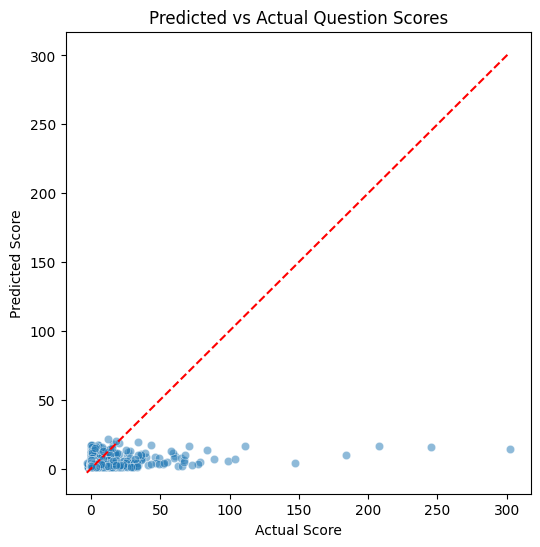

In [18]:
y_pred = model.predict(X_test_log)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Question Scores")
plt.show()

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_log, y_train)
y_pred_rf = rf.predict(X_test_log)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

MAE: 2.069
RMSE: 6.744
R²: 0.162


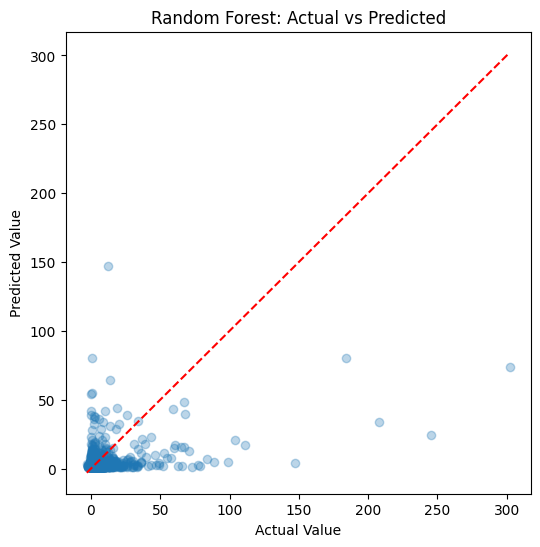

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbr.fit(X_train_log, y_train)
y_pred_gbr = gbr.predict(X_test_log)

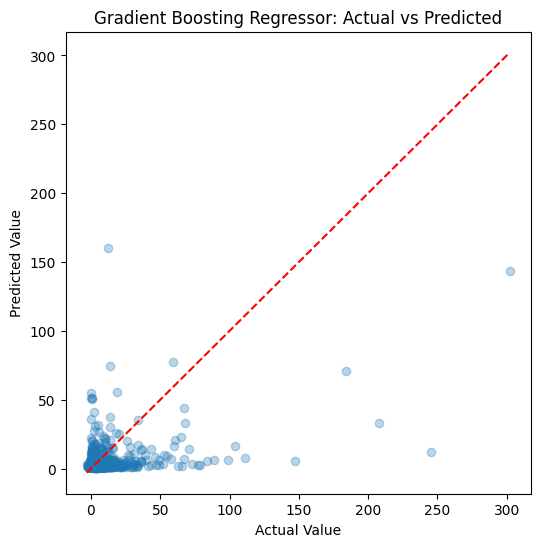

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_gbr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Gradient Boosting Regressor: Actual vs Predicted")
plt.show()

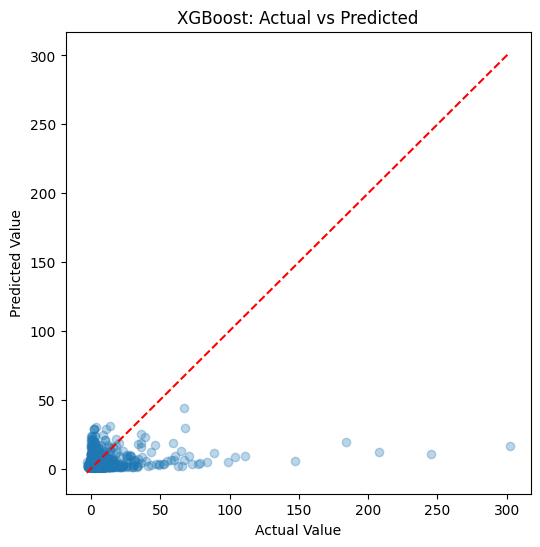

In [24]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train_log, y_train)
y_pred_xgb = xgb.predict(X_test_log)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("XGBoost: Actual vs Predicted")
plt.show()

Compared to question types posts,the features of answers types comments are limited. So we need to consider make the feature engineering more complicated.